# Import

In [ ]:
import sys
import requests
import tarfile
import json
import numpy as np
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt
import cv2

import random
from tqdm import tqdm

import re
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import CSVLogger

from keras.applications import MobileNetV2

from keras.layers import *
from keras.models import Model

Using TensorFlow backend.


In [ ]:
!rm -r sample_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# def

In [ ]:
# text ("1"), title ("2"), list ("3"), table ("4"), figure ("5")

Kat = {
    "1": "text",
    "2": "title",
    "3": "list",
    "4": "table",
    "5": "figure"
}

# Darknet

## laden vom Darknet

In [ ]:
!git clone https://github.com/AlexeyAB/darknet
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

Cloning into 'darknet'...
remote: Enumerating objects: 13939, done.
remote: Total 13939 (delta 0), reused 0 (delta 0), pack-reused 13939
Receiving objects: 100% (13939/13939), 12.56 MiB | 28.83 MiB/s, done.
Resolving deltas: 100% (9505/9505), done.
/content/darknet


In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

# Vorbereitung
Wir brauchen:
- Ein gelabeltes Datenset (Danke IBM)
- .cfg File
- obj.data und obj.names
- train.txt file (optional)

## Funktionen

In [ ]:
def WriteToFile(Name, InhaltInArrayForm):
  file = open(Name, 'w')
  for i in InhaltInArrayForm:
    file.write(i)
    file.write("\n")
  file.close()

In [ ]:
def openTar(Name):
  tar = tarfile.open(Name)
  tar.extractall()
  tar.close()
  print(Name + " entpacked")

## Daten Laden


In [ ]:
%cd ../

/content


## Transformieren



## Func

In [ ]:
def convert_labels(path, b0, b1, b2, b3):

    x1 = b0
    y1 = b1
    x2 = b0 + b2
    y2 = b1 + b3
    """
    Definition: Parses label files to extract label and bounding box
        coordinates.  Converts (x1, y1, x1, y2) KITTI format to
        (x, y, width, height) normalized YOLO format.
    """
    def sorting(l1, l2):
        if l1 > l2:
            lmax, lmin = l1, l2
            return lmax, lmin
        else:
            lmax, lmin = l2, l1
            return lmax, lmin
    size = get_img_shape(path)
    xmax, xmin = sorting(x1, x2)
    ymax, ymin = sorting(y1, y2)
    dw = 1./size[1]
    dh = 1./size[0]
    x = (xmin + xmax)/2.0
    y = (ymin + ymax)/2.0
    w = xmax - xmin
    h = ymax - ymin
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return x,y,w,h


def get_img_shape(path):
    path = path
    img = cv2.imread(path)
    try:
        return img.shape
    except AttributeError:
        print('error! ', path)
        return (None, None, None)

In [ ]:
import os.path
from os import path

def TransformData():
  counter = 0
  !curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/labels.tar.gz --output "labels.tar.gz"
  openTar("labels.tar.gz")
  !rm labels.tar.gz

  StringToJson = 'publaynet/train.json'
  StringToFolder = 'publaynet/train/'

  Labels = []

  with open(StringToJson, 'r') as fp:
      samples = json.load(fp)
  # Index images
  images = {}
  for image in tqdm(samples['images']):
      images[image['id']] = {'file_name': image['file_name'], 'annotations': []}
  for ann in tqdm(samples['annotations']):
      images[ann['image_id']]['annotations'].append(ann)
  InhaltFürTrain = []

  PathToTrain = 'publaynet/train.txt'

  XGröße = 600
  YGröße = 792

  last = ""

  for i, (_, image) in tqdm(enumerate(images.items())):
    FileName = image['file_name']
    last = FileName.split(".")[0]

    if (path.exists(StringToFolder + FileName) is False):
      continue

    counter += 1

    DataFileName = StringToFolder + FileName.split('.')[0] + '.txt'

    Inhalt = []
    
    annotations = image['annotations']
    for pictures in annotations:
      Box = pictures['bbox']
      Category = int(pictures['category_id']) - 1
      #x
      x,w,y,h = convert_labels(StringToFolder + FileName, Box[0], Box[1], Box[2], Box[3])

      TempString = str(Category)
      TempString += " " + str(x)
      TempString += " " + str(w)
      TempString += " " + str(y)
      TempString += " " + str(h)

      Inhalt.append(TempString)
      # print(FileName + "     " + TempString)
      
    InhaltFürTrain.append('../' + StringToFolder + FileName)
    WriteToFile(DataFileName, Inhalt)
  print(".....................................Bilder Geladen: " + str(counter))
  WriteToFile(PathToTrain, InhaltFürTrain)

### obj.names
enthält alle Labels, eins pro Zeile

In [ ]:
%cd darknet/

Name = 'obj.names'
Zusatz = 'data/'
FileName = Zusatz + Name
Inhalt = []

for i in range(1,6):
  Inhalt.append(Kat[str(i)])

WriteToFile(FileName, Inhalt)

%cd ../

/content/darknet
/content


### obj.data

You will also create a **obj.data** file and fill it in like this (change your number of classes accordingly, as well as your backup location)

This backup path is where we will save the weights to of our model throughout training. Create a backup folder in your google drive and put its correct path in this file.

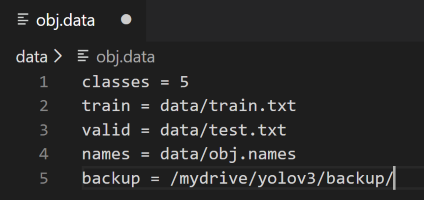



In [ ]:
%cd darknet/

!mkdir ../backup

Inhalt = [
          'classes = 5',
          'train = ../publaynet/train.txt',
          'names = data/obj.names',
          'backup = ../backup'
]
PathToObjData = 'data/obj.data'

WriteToFile(PathToObjData, Inhalt)

%cd ../

/content/darknet
/content


# Training

## Sets Abgeschlossen:
0
1
2
3
4
5

In [ ]:
!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/train-6.tar.gz --output "val.tar.gz"
openTar("val.tar.gz")
!rm val.tar.gz

TransformData()

%cd darknet/
!./darknet detector train data/obj.data ../drive/My\ Drive/data/yolov3_custom.cfg ../drive/My\ Drive/backup/Backup6.weights -dont_show -clear 1
%cd ../

# LöschBefehl
!rm -r publaynet/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.6G  100 12.6G    0     0  4523k      0  0:48:58  0:48:58 --:--:-- 4373k
val.tar.gz entpacked
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  313M  100  313M    0     0  23.4M      0  0:00:13  0:00:13 --:--:-- 26.0M
labels.tar.gz entpacked


100%|██████████| 3263046/3263046 [00:01<00:00, 2628766.38it/s]
335703it [55:12, 101.35it/s]


Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 82 Avg (IOU: 0.860880, GIOU: 0.858119), Class: 0.957530, Obj: 0.809244, No Obj: 0.007831, .5R: 1.000000, .75R: 0.923077, count: 26, class_loss = 1.309646, iou_loss = 0.338685, total_loss = 1.648331 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 94 Avg (IOU: 0.695689, GIOU: 0.685875), Class: 0.996671, Obj: 0.367122, No Obj: 0.000595, .5R: 1.000000, .75R: 0.333333, count: 6, class_loss = 1.599210, iou_loss = 0.424435, total_loss = 2.023645 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 106 Avg (IOU: 0.813879, GIOU: 0.809805), Class: 0.990101, Obj: 0.929271, No Obj: 0.000152, .5R: 1.000000, .75R: 0.800000, count: 5, class_loss = 0.226845, iou_loss = 0.109350, total_loss = 0.336195 
 total_bbox = 870681, rewritten_bbox = 0.326641 % 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 82 Avg (IOU: 0.871158, GIOU: 0.869738), Class: 0.958125, Obj: 0.808597, No Obj

# Ausgabe des Ergebnis


## Vorbereitung 

In [ ]:
%cd darknet/

In [ ]:
!ls

3rdparty		 darknet		 Makefile
backup			 DarknetConfig.cmake.in  net_cam_v3.sh
build			 darknet.py		 obj
build.ps1		 darknet_video.py	 README.md
build.sh		 data			 results
cfg			 image_yolov2.sh	 scripts
chart.png		 image_yolov3.sh	 src
chart_yolov3_custom.png  include		 video_v2.sh
cmake			 json_mjpeg_streams.sh	 video_yolov3.sh
CMakeLists.txt		 LICENSE


In [ ]:
# %cd cfg
# !sed -i 's/batch=64/batch=1/' yolov3_custom.cfg
# !sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom.cfg
# %cd ..


## Test

Vorher noch ein Bild hochladen

In [ ]:
!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/examples.tar.gz --output "examples.tar.gz"
openTar("examples.tar.gz")
!rm examples.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6309k  100 6309k    0     0  13.0M      0 --:--:-- --:--:-- --:--:-- 13.0M
examples.tar.gz entpacked


[Errno 20] Not a directory: 'darknet/'
/content/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8

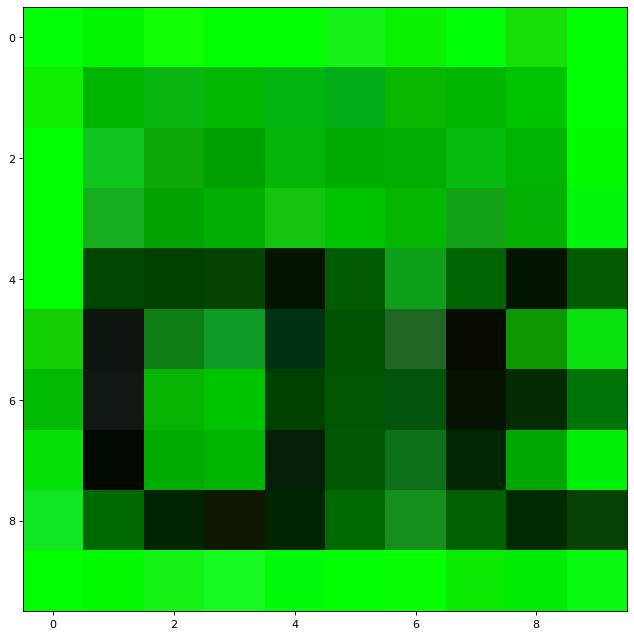

[Errno 20] Not a directory: 'darknet/'
/content/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8

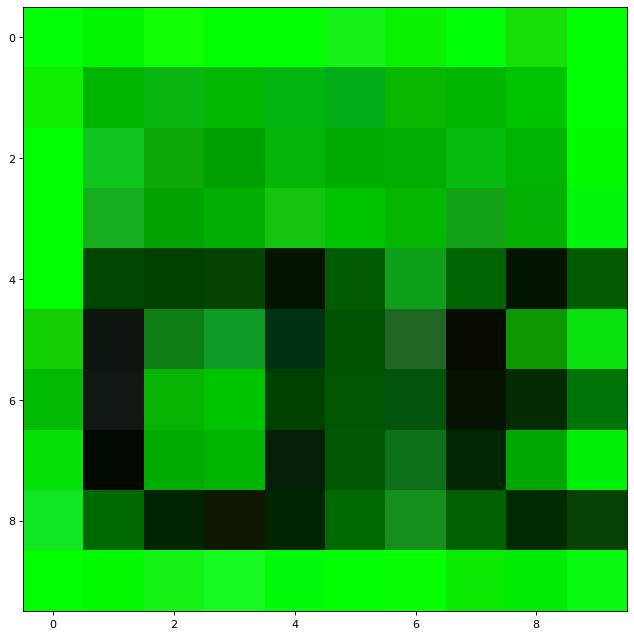

In [ ]:
%cd darknet/
!./darknet detect ../drive/My\ Drive/data/yolov3_custom.cfg ../drive/My\ Drive/backup/Backup3.weights ../examples/PMC3576793_00004.jpg
Ergebnis = Image.open('predictions.jpg')

plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

plt.imshow(Ergebnis)